<a href="https://colab.research.google.com/github/mdhornstein/steins-paradox/blob/main/steins_paradox_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [16]:
p = 3
theta = np.arange(1, 4)
theta

array([1, 2, 3])

In [17]:
theta.shape

(3,)

In [42]:
n = 100
rng = np.random.default_rng()
x = rng.multivariate_normal(mean=theta, cov=np.eye(p), size=n)
x[:10, :]

array([[ 0.77552557,  1.39962849,  3.26135131],
       [ 1.49108381,  1.33721397,  2.84910389],
       [ 1.33918625,  2.64757133,  3.64352616],
       [-0.11360548,  1.34838411,  2.92760429],
       [ 3.59648439,  2.00967755,  2.72120434],
       [ 0.52620065,  2.45847582,  2.85039112],
       [ 0.10481701,  2.45799864,  3.72889626],
       [ 1.43745394,  1.9707932 ,  1.69162692],
       [ 1.89912508,  3.44691169,  4.12700329],
       [ 1.39521975,  0.7410493 ,  3.9821186 ]])

In [43]:
theta.reshape(-1, p)

array([[1, 2, 3]])

In [44]:
errors = x - theta.reshape(-1, p)
errors[:10, :]

array([[-0.22447443, -0.60037151,  0.26135131],
       [ 0.49108381, -0.66278603, -0.15089611],
       [ 0.33918625,  0.64757133,  0.64352616],
       [-1.11360548, -0.65161589, -0.07239571],
       [ 2.59648439,  0.00967755, -0.27879566],
       [-0.47379935,  0.45847582, -0.14960888],
       [-0.89518299,  0.45799864,  0.72889626],
       [ 0.43745394, -0.0292068 , -1.30837308],
       [ 0.89912508,  1.44691169,  1.12700329],
       [ 0.39521975, -1.2589507 ,  0.9821186 ]])

Text(0.5, 1.0, 'Histograms of errors')

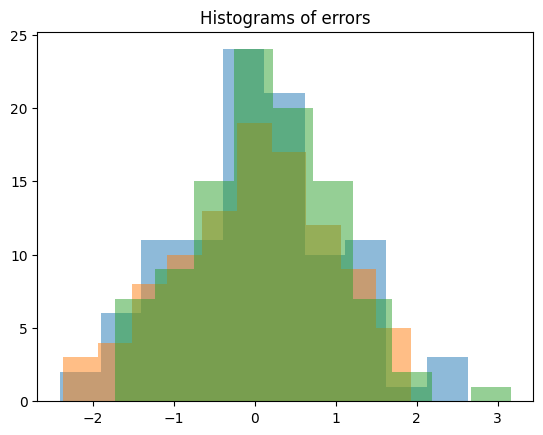

In [45]:
fig, ax = plt.subplots()

for column in errors.T:
  ax.hist(column, alpha=0.5)

ax.set_title("Histograms of errors")

(array([ 3.,  1.,  0.,  3.,  3.,  4., 14., 24., 34., 14.]),
 array([0.78733741, 0.8064331 , 0.82552878, 0.84462446, 0.86372014,
        0.88281582, 0.90191151, 0.92100719, 0.94010287, 0.95919855,
        0.97829424]),
 <BarContainer object of 10 artists>)

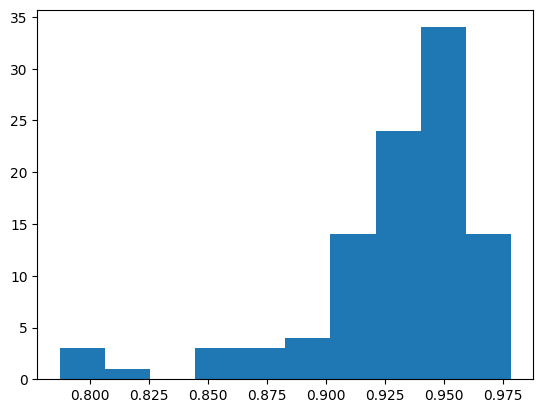

In [51]:
shrinkage_factors = (1 - (p - 2) / (x ** 2).sum(axis=1) )[:, np.newaxis]
plt.hist(shrinkage_factors)

In [85]:
fig = px.histogram(
    shrinkage_factors,
    histnorm="probability",
    labels={"value": "Shrinkage factor"},
    title="Histogram of shrinkage factors")
fig.update_layout(
    yaxis_title="Proportion",
    showlegend=False,
    height=400, width=600)
fig.update_yaxes(tickformat=".0%")
fig.show()

In [90]:
def calculate_mse(X, theta):
  p = len(theta)
  assert X.shape[1] == p
  theta = theta.reshape(1, p)
  mse = ((X - theta) ** 2).sum(axis=1)
  return mse


In [92]:
mse_sample_mean = calculate_mse(x, theta)

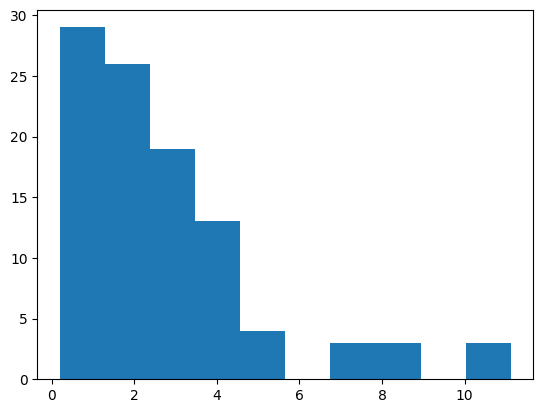

In [94]:
plt.hist(mse_sample_mean)
plt.show()

(array([ 3.,  2.,  9., 20., 24., 23., 10.,  5.,  2.,  2.]),
 array([-1.47579062, -1.14864964, -0.82150867, -0.4943677 , -0.16722672,
         0.15991425,  0.48705522,  0.8141962 ,  1.14133717,  1.46847814,
         1.79561912]),
 <BarContainer object of 10 artists>)

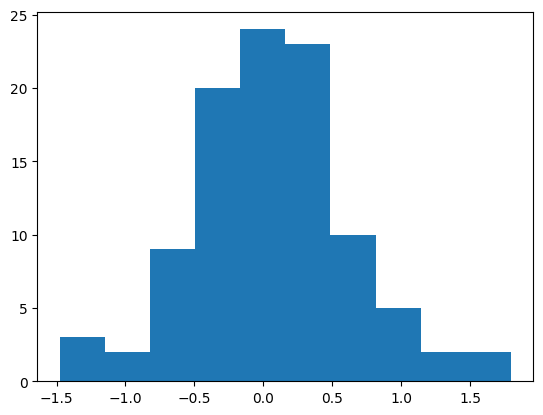

In [97]:
plt.hist((x - theta.reshape(1, p)).mean(axis=1))

In [99]:
stein_estimators = x * shrinkage_factors.reshape(n, 1)

We calcualate the loss for each sample (since there are $n$ samples, there are $n$ values for the loss). The loss is the Euclidean distance between the sample $X_i \in \mathbb{R}^p$ and the true unknown parameter vector $\theta \in \mathbb{R}^p$.  That is, the loss for the $i$th sample is $L(X_i, \theta) = \lVert X_i - \theta \rVert_2^2$.

In [100]:
mse_stein = calculate_mse(stein_estimators, theta)

The estimate of the risk is the average of the loss over all $n$ samples,
$$\frac{1}{n} \sum_{i = 1}^n L(X_i, \theta) = \frac{1}{n} \sum_{i = 1}^n \lVert X_i - \theta \rVert_2^2.
$$

In [102]:
{
    "Stein risk": np.mean(mse_stein),
    "Sample mean risk": np.mean(mse_sample_mean)
}

{'Stein risk': 2.5729866369451395, 'Sample mean risk': 2.7006470609669346}

In [122]:
class SteinSimulation:
  """
  The class stores simulation parameters as instance variables:
    theta: true vector of unknown parameters
    p: dimension of theta
    sigma_sq: variance scaling factor of the multivariate normal distribution
    n: number of samples
    store_data: whether to store the full data matrix

  To run the simulation, call the instance method run_simulation().

  When the simulation runs, the outputs (including shrinkage factors for
  Stein's estimators, and loss/mse for both the naive estimator and Stein's
  estimator) are stored in the dictionary self.sim_data.

  Rerunning the simulation (by calling self.run_simulation) overwrites the
  data in self.sim_data.  Thus, sim_data stores the results of the most recent
  run of the simulation.
  """
  def __init__(self, theta, sigma_sq, n, store_data=False, seed=None):
    # Simulation parameters
    self.p = len(theta)
    self.theta = theta
    self.sigma_sq = sigma_sq
    self.n = n
    self.store_data = store_data

    # Simulation outputs
    self.sim_data = {}

    # RNG
    self.seed = seed
    self.rng = np.random.default_rng(seed)

  @staticmethod
  def calculate_loss(X, theta):
    assert X.shape[1] == len(theta)
    squared_errors = (X - theta.reshape(1, -1)) ** 2
    loss = squared_errors.mean(axis=0)
    return loss

  def run_simulation(self):
    X = rng.multivariate_normal(
        mean=self.theta,
        cov=self.sigma_sq * np.eye(self.p),
        size=self.n)

    loss = self.calculate_loss(X, self.theta)
    mse = np.mean(loss)

    stein_estimators, shrinkage_factors = self.calculate_stein_estimators(X)
    loss_stein = self.calculate_loss(stein_estimators, self.theta)
    mse_stein = np.mean(loss_stein)

    self.sim_data["shrinkage_factors"] = shrinkage_factors
    self.sim_data["loss"] = loss
    self.sim_data["mse"] = mse
    self.sim_data["loss_stein"] = loss_stein
    self.sim_data["mse_stein"] = mse_stein
    if self.store_data:
      self.sim_data["X"] = X

  def calculate_stein_estimators(self, X):
    shrinkage_factors = 1 - (self.p - 2) * self.sigma_sq / (X ** 2).sum(axis=1)
    shrinkage_factors = shrinkage_factors.reshape(self.n, 1)
    stein_estimators = X * shrinkage_factors
    return stein_estimators, shrinkage_factors




In [136]:
theta = 0.001 * np.ones(shape=4)
sigma_sq = 1
n = 1000
sim = SteinSimulation(theta, sigma_sq, n)
sim.run_simulation()

In [137]:
sim.sim_data["mse"]

0.9870417834219087

In [138]:
sim.sim_data["mse_stein"]

0.5237584969029632

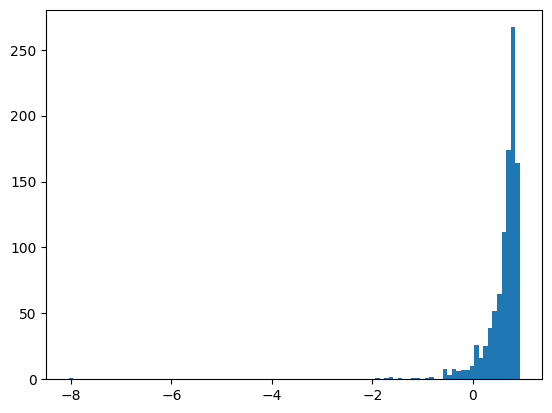

In [129]:
plt.hist(sim.sim_data["shrinkage_factors"], bins=100)
plt.show()